In [331]:
import numpy as np
import pandas as pd
import sklearn as ktl
import pickle
import matplotlib.pylab as plt
import seaborn

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RandomizedSearchCV

import statsmodels.formula.api as smf

from linearmodels.panel import PanelOLS


# Data Manipulation 

### Importing data 

In [332]:
# Sustainable development atlas of Bolivia 

bol = pd.read_csv("/Users/hendrixperalta/Desktop/bolivia/data/sdg_atlas_bolivia/GeoDS4Bolivia.csv")
bol = bol.rename(columns={"asdf_id":"id"})


# Remote sensing data 

sat = pd.read_csv("data/satellite/satelite_data.csv")
#list(sat.columns)

#list(bol.columns)

In [333]:
bol["dep"].value_counts()

dep
La Paz        87
Santa Cruz    56
Cochabamba    47
Potosí        40
Oruro         35
Chuquisaca    29
Beni          19
Pando         15
Tarija        11
Name: count, dtype: int64

### SDG Indexes 

In [334]:
# creating a dataframe with only the composite sdg indexes

sdg_indexes = bol[["id", 'mun_id' , 'index_sdg1','index_sdg2','index_sdg3','index_sdg4','index_sdg5','index_sdg6','index_sdg7', 'index_sdg8','index_sdg9','index_sdg10',
               'index_sdg11','index_sdg13','index_sdg15','index_sdg16','index_sdg17', "imds",]]

#sdg_indexes.isna().sum()

# Export the index variables 
sdg_indexes.to_csv("data/sdg_prediction/sdg_indexes.csv", index=False)

### SDG Indicators 

In [335]:
#list(bol.columns)

In [336]:
sdg_indicators = bol[['id','sdg1_4_abs', 'sdg1_1_dtl_abs', 'sdg1_1_pubn_abs', 'sdg1_2_dd_abs', 'sdg1_4_ebs_abs', 'sdg2_2_cm_abs', 'sdg2_2_wow_abs', 'sdg2_4_apu_abs',
                    'sdg2_4_tm_abs', 'sdg3_2_fb_abs', 'sdg3_2_ffb_abs', 'sdg3_3_cd_abs','sdg3_3_pd_abs', 'sdg3_3_mc_abs', 'sdg3_3_tc_abs', 'sdg3_3_vih_abs',
                    'sdg3_7_bpw_abs', 'sdg4_1_mhs_abs', 'sdg4_1_fhs_abs', 'sdg4_4_heu_abs','sdg4_6_pnl_abs', 'sdg4_c_uti_abs', 'sdg4_c_uts_abs', 'sdg6_1_wdc_abs',
                    'sdg6_2_bsc_abs', 'sdg7_1_wec_abs', 'sdg7_1_rec_abs', 'sdg7_1_cec_abs','sdg7_3_tee_abs', 'sdg8_4_rem_abs', 'sdg8_5_ompr_abs',
                    'sdg8_5_ofpr_abs', 'sdg8_6_mlm_abs', 'sdg8_6_wlm_abs','sdg8_10_dbb_abs', 'sdg9_1_rmun_abs', 'sdg9_5_kcd_abs',
                    'sdg9_5_eutf_abs', 'sdg9_c_hf_abs', 'sdg9_c_tr_abs', 'sdg10_2_dss_abs','sdg11_1_ho_abs', 'sdg11_1_wos_abs', 'sdg11_2_mtv_abs',
                    'sdg13_2_tco2_abs', 'sdg13_2_ad_abs', 'sdg15_1_pa_abs','sdg15_5_rl_abs', 'sdg16_1_rh_abs', 'sdg16_6_aob_abs','sdg16_9_ncr_abs', 'sdg17_5_tpi_abs']]

sdg_indicators = sdg_indicators.fillna(0)
#Normalize the y variable 
sdg_indicators_norm = (sdg_indicators-sdg_indicators.mean())/sdg_indicators.std()

sdg_indicators_norm.to_csv("data/sdg_prediction/sdg_indicators_norm.csv", index=False)

In [337]:
sdg_indicators.describe().round(2)

,id,sdg1_4_abs,sdg1_1_dtl_abs,sdg1_1_pubn_abs,sdg1_2_dd_abs,sdg1_4_ebs_abs,sdg2_2_cm_abs,sdg2_2_wow_abs,sdg2_4_apu_abs,sdg2_4_tm_abs,...,sdg11_1_wos_abs,sdg11_2_mtv_abs,sdg13_2_tco2_abs,sdg13_2_ad_abs,sdg15_1_pa_abs,sdg15_5_rl_abs,sdg16_1_rh_abs,sdg16_6_aob_abs,sdg16_9_ncr_abs,sdg17_5_tpi_abs
count,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,...,339.00,339.00,339.00,339.00,339.00,339.00,339.00,3.390000e+02,339.00,3.390000e+02
mean,169.00,34.42,3377.51,12900.81,1508.88,3188.00,565.01,2139.00,102107.69,107.85,...,2462.38,7898.31,287834.95,880.06,776.81,0.28,2.93,7.415881e+07,419.99,2.118782e+07
std,98.01,24.02,7204.49,26539.75,1849.34,5263.66,1328.02,9848.79,217215.08,338.13,...,3915.07,51739.29,1056448.44,3738.25,3013.36,1.11,21.57,2.701758e+08,1594.82,6.864685e+07
min,0.00,0.10,0.00,141.00,7.00,100.00,12.00,26.00,0.00,0.00,...,26.00,0.00,13.00,0.00,0.00,0.00,0.00,3.506453e+06,2.00,0.000000e+00
25%,84.50,15.70,993.00,4049.50,452.50,953.00,123.00,269.00,5982.50,4.00,...,647.00,0.00,792.50,0.00,0.00,0.00,0.00,1.435302e+07,63.50,3.852256e+06
50%,169.00,27.70,1956.00,7496.00,992.00,2069.00,255.00,501.00,24025.00,20.00,...,1668.00,0.00,10709.00,0.00,0.00,0.00,0.00,2.426501e+07,149.00,6.688063e+06
75%,253.50,51.80,3452.00,13300.50,1883.50,3532.00,522.00,1145.50,84183.00,73.50,...,2783.00,318.50,171186.00,344.50,213.00,0.00,1.00,4.478569e+07,358.50,1.359264e+07
max,338.00,95.60,96160.00,300390.00,15273.00,59801.00,14673.00,149940.00,2084038.00,3786.00,...,54313.00,652334.00,13313574.00,40241.00,33745.00,13.00,368.00,3.784650e+09,27047.00,9.067672e+08


In [338]:
sdg_indicators_norm.describe().round(2)

,id,sdg1_4_abs,sdg1_1_dtl_abs,sdg1_1_pubn_abs,sdg1_2_dd_abs,sdg1_4_ebs_abs,sdg2_2_cm_abs,sdg2_2_wow_abs,sdg2_4_apu_abs,sdg2_4_tm_abs,...,sdg11_1_wos_abs,sdg11_2_mtv_abs,sdg13_2_tco2_abs,sdg13_2_ad_abs,sdg15_1_pa_abs,sdg15_5_rl_abs,sdg16_1_rh_abs,sdg16_6_aob_abs,sdg16_9_ncr_abs,sdg17_5_tpi_abs
count,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,...,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00
mean,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,...,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.72,-1.43,-0.47,-0.48,-0.81,-0.59,-0.42,-0.21,-0.47,-0.32,...,-0.62,-0.15,-0.27,-0.24,-0.26,-0.25,-0.14,-0.26,-0.26,-0.31
25%,-0.86,-0.78,-0.33,-0.33,-0.57,-0.42,-0.33,-0.19,-0.44,-0.31,...,-0.46,-0.15,-0.27,-0.24,-0.26,-0.25,-0.14,-0.22,-0.22,-0.25
50%,0.00,-0.28,-0.20,-0.20,-0.28,-0.21,-0.23,-0.17,-0.36,-0.26,...,-0.20,-0.15,-0.26,-0.24,-0.26,-0.25,-0.14,-0.18,-0.17,-0.21
75%,0.86,0.72,0.01,0.02,0.20,0.07,-0.03,-0.10,-0.08,-0.10,...,0.08,-0.15,-0.11,-0.14,-0.19,-0.25,-0.09,-0.11,-0.04,-0.11
max,1.72,2.55,12.88,10.83,7.44,10.76,10.62,15.01,9.12,10.88,...,13.24,12.46,12.33,10.53,10.94,11.49,16.93,13.73,16.70,12.90


### Air Temperature

In [339]:
# Air temperature

air_temp = pd.read_csv("data/satellite/air_temperature UDel.csv")

# Filter data columns 
air_temp_filtered = air_temp.loc[:, air_temp.columns.str.contains("20")].copy();

# Changing first part of the name 
for col in air_temp_filtered:
    new_name = "airTemp" + col.split(".", 1)[1]
    air_temp_filtered = air_temp_filtered.rename(columns = {col:new_name});
    
air_temp_max = air_temp_filtered[air_temp_filtered.columns[air_temp_filtered.columns.str.contains("max")]];
air_temp_max.columns = air_temp_max.columns.str.replace(".max$", "", regex=True)
air_temp_max['id'] = air_temp['id']

air_temp_min = air_temp_filtered[air_temp_filtered.columns[air_temp_filtered.columns.str.contains("min")]];
air_temp_min.columns = air_temp_min.columns.str.replace(".min$", "", regex=True)
air_temp_min['id'] = air_temp['id']

air_temp_mean = air_temp_filtered.loc[:, air_temp_filtered.columns.str.contains("mean")];
air_temp_mean.columns = air_temp_mean.columns.str.replace(".mean$", "", regex=True)
air_temp_mean['id'] = air_temp['id']

# Test if the id are matching
test = air_temp_mean["airTemp2012"] - air_temp["udel_air_temp_v501_mean.2012.mean"]
print("if the result its 0 its ok", test.sum())

#print(air_temp.isna().sum())

if the result its 0 its ok 0.0


/var/folders/rd/btbmvcm97vb2t3wbhxqqm1tw0000gn/T/ipykernel_35605/3797907362.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_temp_max['id'] = air_temp['id']
/var/folders/rd/btbmvcm97vb2t3wbhxqqm1tw0000gn/T/ipykernel_35605/3797907362.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_temp_min['id'] = air_temp['id']
/var/folders/rd/btbmvcm97vb2t3wbhxqqm1tw0000gn/T/ipykernel_35605/3797907362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

### Distance to coast

In [340]:
coast = pd.read_csv("data/satellite/Distance to coast.csv")
coast = coast.drop(columns = {"asdf_id",'Level', 'gqid', 'shapeGroup', 'shapeID', 'shapeType', "shapeName"})
coast_col = coast.loc[:, coast.columns.str.contains("236")] 

for col in coast_col: 
    new_name = "coast" + col.split(".",1)[1]
    coast.rename(columns = {col:new_name}, inplace=True)
    
coast.columns = coast.columns.str.replace("none.mean","2017mean")
coast.columns = coast.columns.str.replace("none.max","2017max")
coast.columns = coast.columns.str.replace("none.min","2017min")

#coast.isna().sum

### Distance to Diamond Deposits

In [341]:
dia = pd.read_csv("data/satellite/Distance to diamond deposits.csv")
dia.drop(columns = {'asdf_id','Level', 'gqid','shapeGroup', 'shapeID','shapeType'}, inplace=True)
dia_col = dia.loc[:, dia.columns.str.contains("2017")] 

for col in dia_col: 
    new_name = "diamond2017" + col.split(".",1)[1]
    dia.rename(columns = {col:new_name}, inplace=True)
    
dia.columns = dia.columns.str.replace("none.mean","mean")
dia.columns = dia.columns.str.replace("none.max","max")
dia.columns = dia.columns.str.replace("none.min","min")

#dia.isna().sum()

### Distance to drug cultivation 

In [342]:
offset = 10 
dist_drug = pd.read_csv("data/satellite/Distance to drug cultivation.csv")
dist_drug = dist_drug.drop(columns = {'asdf_id','Level', 'gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
dist_drug_col = dist_drug.loc[:, dist_drug.columns.str.contains("drug")]

for col in dist_drug_col: 
    new_name = "dist_drug2017" + col.split(".",2)[2]
    dist_drug.rename(columns = {col:new_name}, inplace = True)

#drug_cult.isna().sum()

### Distance to road

In [343]:
road = pd.read_csv("data/satellite/Distance to road.csv")
road = road.drop(columns = {'asdf_id', 'Level', 'gqid', 'shapeGroup', 'shapeID', 'shapeType', "shapeName"})
road_col = road.loc[:, road.columns.str.contains("road")]

for col in road_col: 
    new_name = "distance_road2017" + col.split(".",1)[1]
    road.rename(columns = {col:new_name}, inplace = True)

road.columns = road.columns.str.replace("none.mean","mean")
road.columns = road.columns.str.replace("none.max","max")
road.columns = road.columns.str.replace("none.min","min")
road["ln_distance_road2017mean"] = np.log(road["distance_road2017mean"])
#road.isna().sum()


### Distance to water

In [344]:
water = pd.read_csv("data/satellite/distance to water.csv")
water = water.drop(columns = {'asdf_id','Level', 'gqid','shapeGroup', 'shapeID', 'shapeType', "shapeName"})
water_col = water.loc[:, water.columns.str.contains("water")]

for col in water_col: 
    new_name = "dist_water2017" + col.split(".",1)[1]
    water.rename(columns = {col:new_name}, inplace = True)

water.columns = water.columns.str.replace("none.mean","mean")
water.columns = water.columns.str.replace("none.max","max")
water.columns = water.columns.str.replace("none.min","min")

#water.isna().sum()

### Drug cultivation

In [345]:
offset = 10 
drug_cult = pd.read_csv("data/satellite/Drug cultivation site 2017.csv")
drug_cult = drug_cult.drop(columns = {'asdf_id','Level', 'gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
drug_cult_col = drug_cult.loc[:, drug_cult.columns.str.contains("categorical")]

for col in drug_cult_col: 
    new_name = "drug_cult2017" + col.split(".categorical_",1)[1]
    drug_cult.rename(columns = {col:new_name}, inplace = True)

#drug_cult

### ESA Landcover

In [346]:
esa_land = pd.read_csv("data/satellite/ESA landcover 2012-2016.csv")
esa_land2012 = esa_land.loc[:, esa_land.columns.str.contains("2012|id|name")]
esa_land2012 = esa_land2012.drop(columns = {'gqid', "asdf_id"})
esa_land2012_col = esa_land2012.loc[:, esa_land2012.columns.str.contains("categorical")]

for col in esa_land2012_col:
    new_name = "esa_land2012" + col.split("categorical",1)[1]
    esa_land2012.rename(columns = {col:new_name}, inplace=True)

### GEE modis 

In [393]:
gee_modis = pd.read_csv("data/satellite/GEE modis 2012-2017.csv")
gee_modis2012 = gee_modis[gee_modis["year"] == 2012]
gee_modis2012 = gee_modis2012.drop(columns = {'system:index','country','level','system:time_start','.geo',"year","name"})
gee_modis2012 = gee_modis2012.add_prefix("gee_")
gee_modis2012 = gee_modis2012.rename(columns = {"gee_id":"id"})


### GISA 

In [348]:
gisa = pd.read_csv("data/satellite/GISA 2012-2019.csv")
gisa = gisa.drop(columns = {'system:index','country','level','system:time_start','.geo'})
gisa2012 = gisa[gisa["year"]==2012]
gisa2012 = gisa2012.rename(columns = {"total_area":"gisa2012"})
#gisa2012.isna().sum()

### GHSL

In [349]:
ghsl = pd.read_csv("data/satellite/global_human_settlement_layer.csv")
ghsl = ghsl.drop(columns=['system:index', 'country', 'level', 'system:time_start', '.geo', "year", "name"])
ghsl = ghsl.rename(columns = {"total_volume": "ghsl2015"})
ghsl["ln_ghsl2015"] = np.log(ghsl["ghsl2015"])

### Gold deposits

In [350]:
#gold =  pd.read_csv("data/satellite/Gold deposits.csv")

### Physical elevation 

In [351]:
elev = pd.read_csv("data/satellite/Physical Elevation.csv")
elev = elev.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
elev_col = elev.loc[:, elev.columns.str.contains("elevation")]

for col in elev_col:
    new_name = "elev2017" + col.split(".",2)[2]
    elev = elev.rename(columns = {col:new_name})

### Malaria atlas 

In [352]:
offset = 1000 

mala = pd.read_csv("data/satellite/Malaria Atlas.csv")
mala2012 = mala.drop(columns = {'asdf_id','Level', 'gqid','shapeGroup','shapeID','shapeType','map_pf_incidence_rate.2013.mean', 'map_pf_incidence_rate.2013.min',
       'map_pf_incidence_rate.2013.max', 'map_pf_incidence_rate.2013.count','map_pf_incidence_rate.2014.mean', 'map_pf_incidence_rate.2014.min',
       'map_pf_incidence_rate.2014.max', 'map_pf_incidence_rate.2014.count','map_pf_incidence_rate.2015.mean', 'map_pf_incidence_rate.2015.min',
       'map_pf_incidence_rate.2015.max', 'map_pf_incidence_rate.2015.count','map_pf_incidence_rate.2016.mean', 'map_pf_incidence_rate.2016.min',
       'map_pf_incidence_rate.2016.max', 'map_pf_incidence_rate.2016.count','map_pf_incidence_rate.2017.mean', 'map_pf_incidence_rate.2017.min',
       'map_pf_incidence_rate.2017.max', 'map_pf_incidence_rate.2017.count','map_pf_incidence_rate.2018.mean', 'map_pf_incidence_rate.2018.min',
       'map_pf_incidence_rate.2018.max', 'map_pf_incidence_rate.2018.count','map_pf_incidence_rate.2019.mean', 'map_pf_incidence_rate.2019.min',
       'map_pf_incidence_rate.2019.max', 'map_pf_incidence_rate.2019.count', "shapeName"})

#mala2012 = mala.loc[:, mala.columns.str.contains("2012|id", regex=True)]
mala2012_col = mala2012.loc[:, mala2012.columns.str.contains("rate")]

for col in mala2012_col:
    new_name = "mal_inci_rt_" + col.split(".",2)[2]
    mala2012 = mala2012.rename(columns = {col:new_name})


### Photovoltaic potential 

In [353]:
photo = pd.read_csv("data/satellite/Photovoltaic power potential.csv")
photo = photo.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
photo_col = photo.loc[:,photo.columns.str.contains("global")]

for col in photo_col:
    new_name = "photov2019" + col.split(".",2)[2]
    photo = photo.rename(columns = {col:new_name})

### Time to major city 

In [354]:
time_to_city = pd.read_csv("data/satellite/time to major city.csv")
time_to_city = time_to_city.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
time_to_city_col = time_to_city.loc[:, time_to_city.columns.str.contains("access")]

for col in time_to_city_col:
    new_name = "access2016" + col.split(".",2)[2]
    time_to_city = time_to_city.rename(columns = {col:new_name})

#time_to_city

### Precipitation CRU

In [355]:
prec = pd.read_csv("./data/satellite/Yearly precipitaiton CRU.csv")
prec = prec.loc[:,prec.columns.str.contains("2012|id")]
prec = prec.drop(columns= {"gqid","asdf_id"})
prec_col = prec.loc[:,prec.columns.str.contains("2012")]

for col in prec_col:
    new_name = "precCRU2012" + col.split(".", 2)[2]
    prec = prec.rename(columns= {col:new_name})

### Ground Slope 

In [356]:
slope = pd.read_csv("./data/satellite/Ground Slope.csv")
slope = slope.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
slope_col = slope.loc[:, slope.columns.str.contains("slope")]

for col in slope_col:
    new_name = "slope500m2017" + col.split(".",2)[2]
    slope = slope.rename(columns= {col:new_name})

#slope

### Modis Landcover

In [426]:
mod_landcover = pd.read_csv("./data/satellite/modis landcover.csv")
mod_landcover = mod_landcover.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', 
                                              "shapeName", 'modis_landcover_51.2012.categorical_unclassified',
                                              'modis_landcover_51.2012.categorical_fill_value', "id"})
mod_landcover_col = mod_landcover.loc[:, mod_landcover.columns.str.contains("modis")]

for col in mod_landcover_col: 
    new_name = "modis_landcover2012_" + col.split("_",3)[3]
    mod_landcover = mod_landcover.rename(columns={col:new_name})

# Creating Aggregated variables 
mod_landcover_percent = mod_landcover.div(mod_landcover['modis_landcover2012_count'], axis=0)*100
mod_landcover_percent.reset_index(names="id", inplace=True)

forest_col = mod_landcover.columns[mod_landcover.columns.str.contains("forest")]
mod_landcover_percent["modis_landcover2012_full_forest"] = (mod_landcover_percent.loc[:,forest_col]).sum(axis=1)

mod_landcover_percent.columns


Index(['id', 'modis_landcover2012_barren_or_sparsely_vegetated',
       'modis_landcover2012_count', 'modis_landcover2012_grasslands',
       'modis_landcover2012_open_shrublands', 'modis_landcover2012_water',
       'modis_landcover2012_evergreen_needleleaf_forest',
       'modis_landcover2012_evergreen_broadleaf_forest',
       'modis_landcover2012_deciduous_needleleaf_forest',
       'modis_landcover2012_deciduous_broadleaf_forest',
       'modis_landcover2012_mixed_forest',
       'modis_landcover2012_closed_shrublands',
       'modis_landcover2012_woody_savannas', 'modis_landcover2012_savannas',
       'modis_landcover2012_permanent_wetlands',
       'modis_landcover2012_croplands',
       'modis_landcover2012_urban_and_builtup',
       'modis_landcover2012_cropland_natural_vegetation_mosaic',
       'modis_landcover2012_snow_and_ice', 'modis_landcover2012_full_forest'],
      dtype='object')

## Create a dataframe with only satellite data


### Unify bol and sat data

In [357]:
# Satellite dataframes with the same construction 
dataframes = [coast,dia,dist_drug,road,water,drug_cult,esa_land2012, gee_modis2012, ghsl, elev, mala2012, gisa2012]

# Satellite data from the Bolivia dataset 

satellite_full = bol[["id", 'mun_id' , 'tr400_pop2012', "ln_t400NTLpc2012",'ln_t400NTLpc2020',]]

# Other satellite data
sat_filtered = sat[["id", 'egdp2012','agr_land2012','urb_land2012','pm25_2012','land_temp2012',]]

# Merging the satellite dataframes 
satellite_full = satellite_full.merge(sat_filtered, on="id", how="outer")
satellite_full = satellite_full.merge(air_temp_mean[["airTemp2012","id"]], on="id", how="outer")

for df in dataframes: 
    satellite_full = satellite_full.merge(df, on="id", how="outer")

# Export satellite data
#satellite_full.to_csv("data/sdg_prediction/satellite_full.csv")

#list(satellite_full.columns)

#satellite_full

### Create a df with the Relevant satellite data and its manipulations 

In [358]:
# Creation of the satellite dataframe
offset = 1000  

sat_mod = pd.DataFrame()

# Identifiers  
sat_mod["id"] = satellite_full["id"]
sat_mod["dep"] = bol["dep"]

# Log EGDP per capita - sum EGDP
satellite_full["EGDPpc2012"] = (satellite_full["egdp2012"]*1000000/ bol["tr400_pop2012"])
sat_mod["lnEGDPpc2012"] = np.log(satellite_full["EGDPpc2012"])

# Land cover agriculture/urban
sat_mod["lnagr_land2012"] = np.log(satellite_full["agr_land2012"] + offset)
sat_mod["lnurb_land2012"] = np.log(satellite_full["urb_land2012"] + offset)

# Urban landcover percentage
satellite_full["total_land2012"] = satellite_full["agr_land2012"] + satellite_full["urb_land2012"]
satellite_full["perUrb_land2012"] = satellite_full["urb_land2012"] / satellite_full["total_land2012"]
sat_mod["ln_perUrb_land2012"] = np.log(satellite_full["perUrb_land2012"].fillna(0) + offset)

# Population
sat_mod["ln_tr400_pop2012"] = np.log(satellite_full["tr400_pop2012"])

# PM2.5
sat_mod["ln_pm25_2012"] = np.log(satellite_full["pm25_2012"])

# Surface temperature
sat_mod["ln_land_temp2012"] = np.log(satellite_full["land_temp2012"])

# NTL
sat_mod["ln_t400NTLpc2012"] = satellite_full["ln_t400NTLpc2012"]

# Distance to road 
sat_mod["ln_dist_road2017"] = np.log(satellite_full["distance_road2017mean"]) 

# GHSL 
sat_mod["ln_ghsl2015"] = satellite_full["ln_ghsl2015"]

# Distance Diamond deposits 
sat_mod["dist_diamond2015"] = satellite_full["diamond2017mean"]

#Malaria Rate
sat_mod["ln_mal_inci_rt_mean"] = np.log(mala2012["mal_inci_rt_mean"]+offset)

#Distance to water
sat_mod["ln_dist_water2017mean"] = np.log(water["dist_water2017mean"])

# Physical Elevation 
sat_mod['ln_elev2017mean'] = np.log(elev['elev2017mean']+offset)

# Distance to Drug cultivation
sat_mod["ln_dist_drug2017mean"] = np.log(dist_drug["dist_drug2017mean"]+offset)

# Photovoltaic Potential 
sat_mod['photov2019mean'] = photo['photov2019mean']

# Time to major city 

sat_mod["access2016mean"] = time_to_city["access2016mean"]
sat_mod["ln_access2016mean"] = np.log(sat_mod["access2016mean"])

sat_mod["slope500m2017mean"] = slope["slope500m2017mean"]
sat_mod["ln_slope500m2017mean"] = np.log(slope["slope500m2017mean"])

sat_mod["precCRU2012min"] = prec["precCRU2012min"]
sat_mod["ln_precCRU2012min"] = np.log(prec["precCRU2012min"])

sat_mod.to_csv("data/sdg_prediction/sat_mod.csv", index=False)

In [359]:
#Standarizing the labels

sta_indicators = bol[['sdg1_4_abs', 'sdg1_1_dtl_abs', 'sdg1_1_pubn_abs', 'sdg1_2_dd_abs',
               'sdg1_4_ebs_abs', 'sdg2_2_cm_abs', 'sdg2_2_wow_abs', 'sdg2_4_apu_abs',
               'sdg2_4_tm_abs', 'sdg3_2_fb_abs', 'sdg3_2_ffb_abs', 'sdg3_3_cd_abs',
               'sdg3_3_pd_abs', 'sdg3_3_mc_abs', 'sdg3_3_tc_abs', 'sdg3_3_vih_abs',
               'sdg3_7_bpw_abs', 'sdg4_1_mhs_abs', 'sdg4_1_fhs_abs', 'sdg4_4_heu_abs',
               'sdg4_6_pnl_abs', 'sdg4_c_uti_abs', 'sdg4_c_uts_abs', 'sdg6_1_wdc_abs',
               'sdg6_2_bsc_abs', 'sdg7_1_wec_abs', 'sdg7_1_rec_abs', 'sdg7_1_cec_abs',
               'sdg7_3_tee_abs', 'sdg8_4_rem_abs', 'sdg8_5_ompr_abs',
               'sdg8_5_ofpr_abs', 'sdg8_6_mlm_abs', 'sdg8_6_wlm_abs',
               'sdg8_10_dbb_abs', 'sdg9_1_rmun_abs', 'sdg9_5_kcd_abs',
               'sdg9_5_eutf_abs', 'sdg9_c_hf_abs', 'sdg9_c_tr_abs', 'sdg10_2_dss_abs',
               'sdg11_1_ho_abs', 'sdg11_1_wos_abs', 'sdg11_2_mtv_abs',
               'sdg13_2_tco2_abs', 'sdg13_2_ad_abs', 'sdg15_1_pa_abs',
               'sdg15_5_rl_abs', 'sdg16_1_rh_abs', 'sdg16_6_aob_abs',
               'sdg16_9_ncr_abs', 'sdg17_5_tpi_abs', 'sdg1_4_abs_norm',
               'index_sdg1','index_sdg2','index_sdg3','index_sdg4','index_sdg5','index_sdg6','index_sdg7',
               'index_sdg8','index_sdg9','index_sdg10','index_sdg11','index_sdg13','index_sdg15',
               'index_sdg16','index_sdg17']]

# Standarizing the labels 

sta_indicators = (sta_indicators - sta_indicators.mean())/sta_indicators.std()
#norm_df = (norm_df - norm_df.min()) / (norm_df.max()-norm_df.min())
sta_indicators = sta_indicators.reset_index()
sta_indicators = sta_indicators.rename(columns = {"index":"id"})

# Export the standarized sdg indicators 
sta_indicators.to_csv("data/sdg_prediction/sta_indicators.csv", index=False)

## Descriptive statistics

In [360]:
# Merging the labels and features datasets 

desc_df = sat_mod.merge(sta_indicators, on="id", how="outer")
desc_df = desc_df = desc_df.drop("id", axis=1)
desc_table = desc_df.describe().round(2)
desc_table = desc_table.transpose()
desc_table
#desc_table.to_csv("description_statistics.csv")

,count,mean,std,min,25%,50%,75%,max
lnEGDPpc2012,339.0,8.40,1.24,4.71,7.53,8.24,9.16,11.69
lnagr_land2012,339.0,6.97,0.18,6.91,6.91,6.91,6.94,8.37
lnurb_land2012,339.0,7.00,0.39,6.91,6.91,6.91,6.93,10.27
ln_perUrb_land2012,339.0,6.91,0.00,6.91,6.91,6.91,6.91,6.91
ln_tr400_pop2012,339.0,9.34,1.15,6.25,8.69,9.29,9.90,14.17
...,...,...,...,...,...,...,...,...
index_sdg11,339.0,-0.00,1.00,-2.75,-0.62,-0.07,0.47,4.57
index_sdg13,339.0,0.00,1.00,-3.89,-0.47,0.34,0.63,1.78
index_sdg15,339.0,0.00,1.00,-2.86,-0.22,-0.21,-0.02,2.45
index_sdg16,339.0,0.00,1.00,-4.25,-0.49,0.19,0.68,2.05


# **Data exploration**

In [361]:
sat_mod.describe().round(2)

,id,lnEGDPpc2012,lnagr_land2012,lnurb_land2012,ln_perUrb_land2012,ln_tr400_pop2012,ln_pm25_2012,ln_land_temp2012,ln_t400NTLpc2012,ln_dist_road2017,...,ln_dist_water2017mean,ln_elev2017mean,ln_dist_drug2017mean,photov2019mean,access2016mean,ln_access2016mean,slope500m2017mean,ln_slope500m2017mean,precCRU2012min,ln_precCRU2012min
count,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,...,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00
mean,169.00,8.40,6.97,7.00,6.91,9.34,3.12,5.70,13.03,8.64,...,10.35,8.02,11.39,4.88,472.41,5.97,6.33,1.27,59.35,3.91
std,98.01,1.24,0.18,0.39,0.00,1.15,0.29,0.01,1.67,0.65,...,0.95,0.56,1.37,0.81,278.47,0.68,5.19,1.31,33.96,0.63
min,0.00,4.71,6.91,6.91,6.91,6.25,2.11,5.66,0.86,6.46,...,5.76,7.04,6.91,3.44,10.68,2.37,0.11,-2.19,4.31,1.46
25%,84.50,7.53,6.91,6.91,6.91,8.69,2.89,5.69,12.05,8.23,...,9.83,7.50,10.80,4.06,284.46,5.65,1.38,0.32,34.95,3.55
50%,169.00,8.24,6.91,6.91,6.91,9.29,3.09,5.70,13.12,8.57,...,10.46,8.28,11.62,5.01,437.15,6.08,5.91,1.78,53.88,3.99
75%,253.50,9.16,6.94,6.93,6.91,9.90,3.36,5.71,14.27,9.08,...,10.99,8.49,12.40,5.61,608.40,6.41,9.73,2.28,70.06,4.25
max,338.00,11.69,8.37,10.27,6.91,14.17,3.65,5.72,17.07,10.41,...,12.45,8.63,13.36,6.49,2363.90,7.77,22.47,3.11,155.01,5.04


In [362]:
sdg_indexes.describe().round(2)

,id,mun_id,index_sdg1,index_sdg2,index_sdg3,index_sdg4,index_sdg5,index_sdg6,index_sdg7,index_sdg8,index_sdg9,index_sdg10,index_sdg11,index_sdg13,index_sdg15,index_sdg16,index_sdg17,imds
count,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00
mean,169.00,42887.39,37.46,40.68,75.21,53.25,73.06,35.80,52.26,44.98,35.53,66.05,37.54,72.22,53.89,73.84,14.01,51.05
std,98.01,23669.93,20.95,11.05,7.36,12.11,9.72,16.23,14.93,10.51,15.20,14.22,12.52,15.49,18.82,9.68,11.61,6.77
min,0.00,10101.00,0.06,21.44,50.23,12.37,37.79,0.00,24.94,14.95,0.62,10.26,3.05,11.90,0.00,32.72,0.00,35.70
25%,84.50,21101.50,21.64,30.78,70.38,46.61,68.28,25.49,40.94,38.12,24.33,57.95,29.77,64.93,49.79,69.06,5.69,47.00
50%,169.00,40301.00,34.76,37.98,76.17,54.38,74.24,34.92,50.15,45.20,34.91,68.62,36.71,77.41,50.00,75.63,10.89,50.50
75%,253.50,70153.00,51.88,49.11,80.75,61.11,79.62,44.70,62.29,51.92,46.04,75.69,43.42,82.00,53.59,80.40,18.31,54.85
max,338.00,90503.00,90.46,71.37,89.05,85.82,93.54,95.01,96.53,72.51,78.86,95.71,94.81,99.77,100.00,93.66,65.25,80.20


In [363]:
reg_data = sat_mod.merge(sdg_indexes[["id","imds"]], on="id", how="outer")

mod = smf.ols("imds ~  ln_t400NTLpc2012 + ln_tr400_pop2012 + lnEGDPpc2012 + ln_pm25_2012 ", 
              data=reg_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   imds   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     52.92
Date:                Sat, 06 Jul 2024   Prob (F-statistic):           1.65e-34
Time:                        19:15:27   Log-Likelihood:                -1045.7
No. Observations:                 339   AIC:                             2101.
Df Residuals:                     334   BIC:                             2121.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.8725      4.370  

In [364]:
missing_labels = sdg_indexes.columns[sdg_indexes.isna().any()]
missing_labels

Index([], dtype='object')

### Histogram plots 

[Text(0.5, 1.0, 'Precipitaiton CRU')]

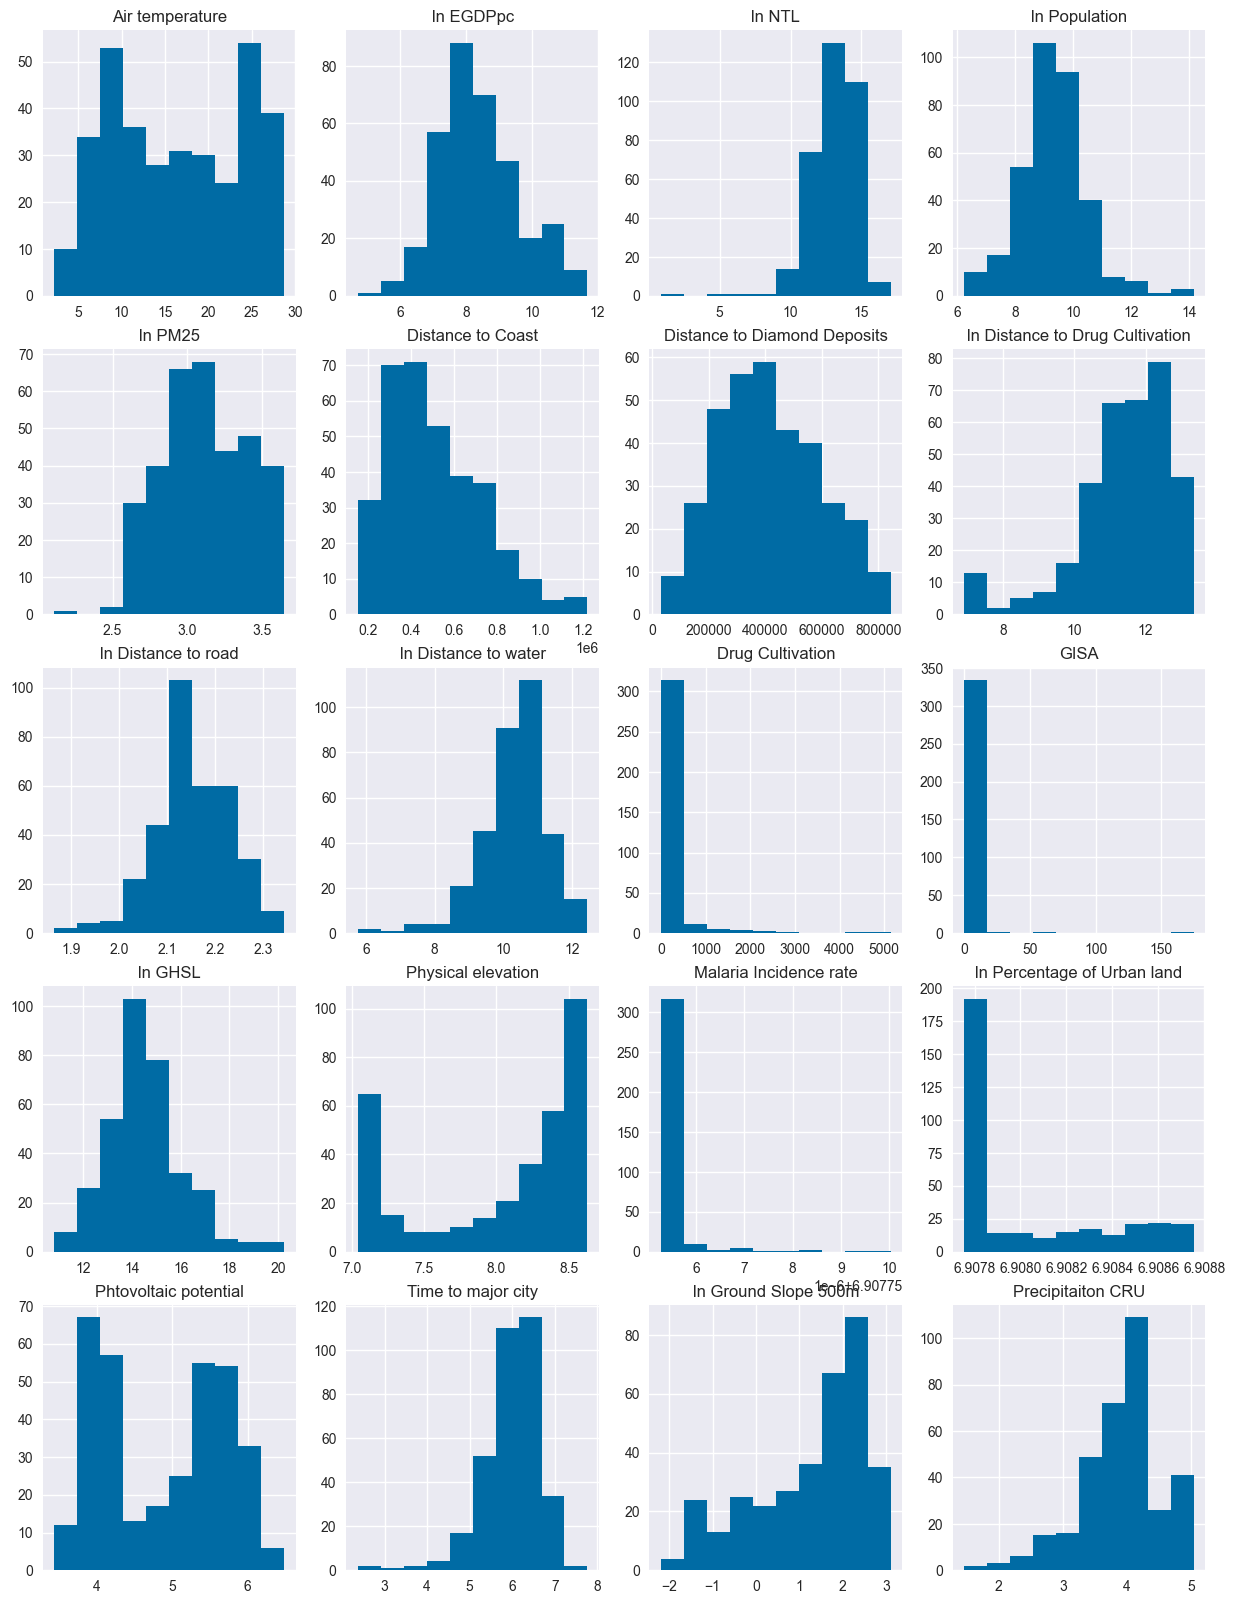

In [365]:
plt.style.use("tableau-colorblind10")

fig, ((ax0, ax1, ax2,ax3), 
      (ax4, ax5,ax6, ax7),
      (ax8,ax9, ax10, ax11),
      (ax12, ax13, ax14,ax15), 
      (ax16, ax17, ax18, ax19)) = plt.subplots(nrows=5,
                                                ncols=4,
                                                figsize=(15,20)
                                                     )
ax0.hist(satellite_full["airTemp2012"])
ax0.set(title="Air temperature")

ax1.hist(sat_mod["lnEGDPpc2012"])
ax1.set(title="ln EGDPpc")

ax2.hist(sat_mod["ln_t400NTLpc2012"])
ax2.set(title="ln NTL")

ax3.hist(sat_mod["ln_tr400_pop2012"])
ax3.set(title= "ln Population")

ax4.hist(sat_mod["ln_pm25_2012"])
ax4.set(title= "ln PM25")

ax5.hist(satellite_full["coast2017mean"])
ax5.set(title= "Distance to Coast")

ax6.hist(sat_mod["dist_diamond2015"])
ax6.set(title="Distance to Diamond Deposits")

ax7.hist(sat_mod["ln_dist_drug2017mean"])
ax7.set(title = "ln Distance to Drug Cultivation")

ax8.hist(np.log(sat_mod["ln_dist_road2017"]))
ax8.set(title = "ln Distance to road")

ax9.hist(sat_mod["ln_dist_water2017mean"])
ax9.set(title = "ln Distance to water")

ax10.hist(satellite_full["drug_cult2017coca_bush"])
ax10.set(title = "Drug Cultivation")

ax11.hist(satellite_full["gisa2012"])
ax11.set(title = "GISA");

ax12.hist(sat_mod["ln_ghsl2015"])
ax12.set(title = "ln GHSL")

ax13.hist(sat_mod["ln_elev2017mean"])
ax13.set(title = "Physical elevation")

ax14.hist(sat_mod["ln_mal_inci_rt_mean"])
ax14.set(title = "Malaria Incidence rate")

ax15.hist(sat_mod["ln_perUrb_land2012"])
ax15.set(title = "ln Percentage of Urban land")

ax16.hist(sat_mod['photov2019mean'])
ax16.set(title = "Phtovoltaic potential")

ax17.hist(sat_mod["ln_access2016mean"])
ax17.set(title = "Time to major city")

ax18.hist(sat_mod["ln_slope500m2017mean"])
ax18.set(title = "ln Ground Slope 500m")

ax19.hist(sat_mod["ln_precCRU2012min"])
ax19.set(title = "Precipitaiton CRU")

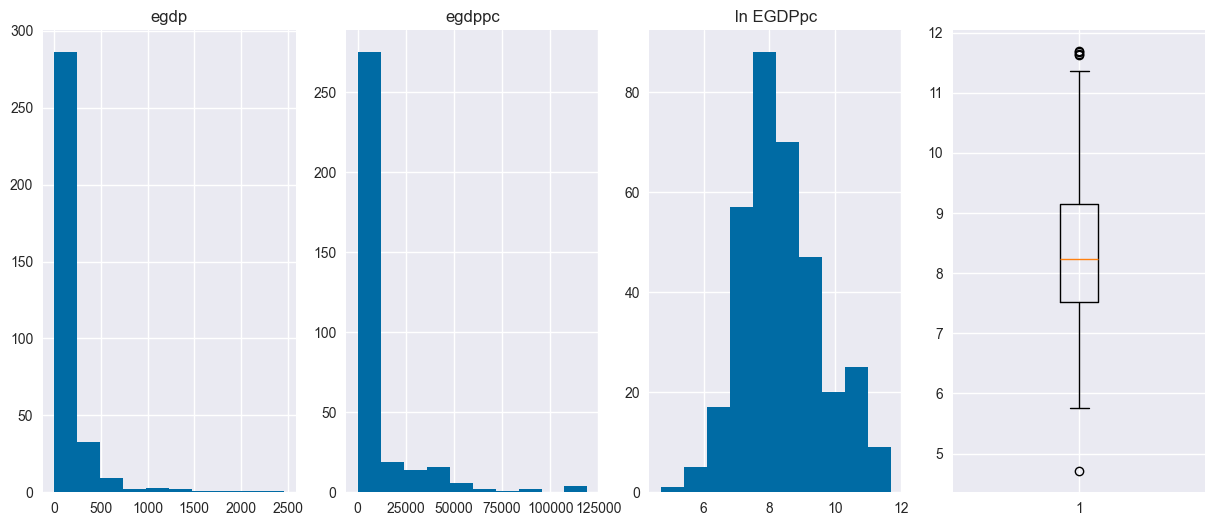

In [366]:
plt.style.use("tableau-colorblind10")

fig, (ax0, ax1, ax2, ax4) = plt.subplots(nrows=1,
                                 ncols=4,
                                 figsize=(15,6)
                                 )
ax0.hist(sat["egdp2012"])
ax0.set(title="egdp")

ax1.hist(satellite_full["EGDPpc2012"])
ax1.set(title= "egdppc")

ax2.hist(sat_mod["lnEGDPpc2012"])
ax2.set(title="ln EGDPpc")

ax4.boxplot(sat_mod["lnEGDPpc2012"]);


In [367]:
#plt.style.available

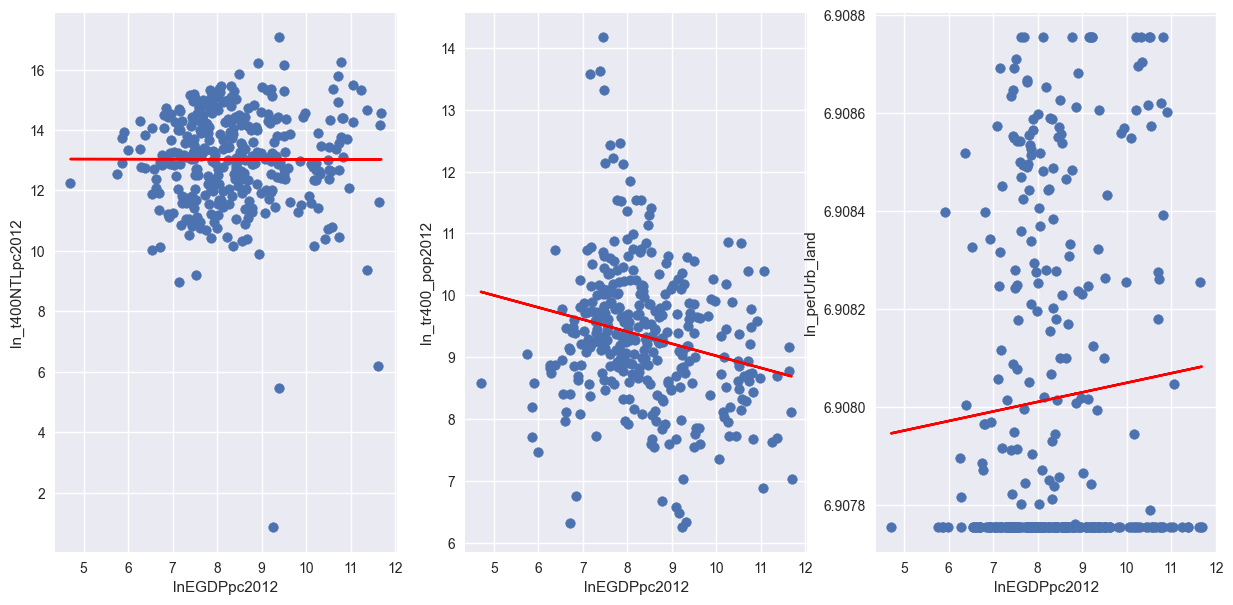

In [368]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=sat_mod['lnEGDPpc2012'], y=sat_mod["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(sat_mod["lnEGDPpc2012"], sat_mod['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(sat_mod["lnEGDPpc2012"],p(sat_mod["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=sat_mod["lnEGDPpc2012"], y=sat_mod['ln_tr400_pop2012'])
ax1.set(xlabel="lnEGDPpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(sat_mod["lnEGDPpc2012"], sat_mod['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(sat_mod["lnEGDPpc2012"],p(sat_mod["lnEGDPpc2012"]),"r-")

#----- ax2
ax2.scatter(x=sat_mod["lnEGDPpc2012"], y=sat_mod['ln_perUrb_land2012'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="ln_perUrb_land")

# add trendline
z = np.polyfit(sat_mod["lnEGDPpc2012"], sat_mod['ln_perUrb_land2012'], 1)
p = np.poly1d(z)
ax2.plot(sat_mod["lnEGDPpc2012"],p(sat_mod["lnEGDPpc2012"]),"r-")



In [369]:
egdp_ntl = sat_mod["lnEGDPpc2012"].corr(sat_mod['ln_t400NTLpc2012'])
egdp_pop = sat_mod["lnEGDPpc2012"].corr(sat_mod['ln_tr400_pop2012'])
egdp_urb = sat_mod["lnEGDPpc2012"].corr(sat_mod['ln_perUrb_land2012'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

Correlation of egdp and ntl: -0.0013160348349785576
Correlation of egdp and pop: -0.21141855279870278
Correlation of egdp and Urban land %: 0.06980531985494491


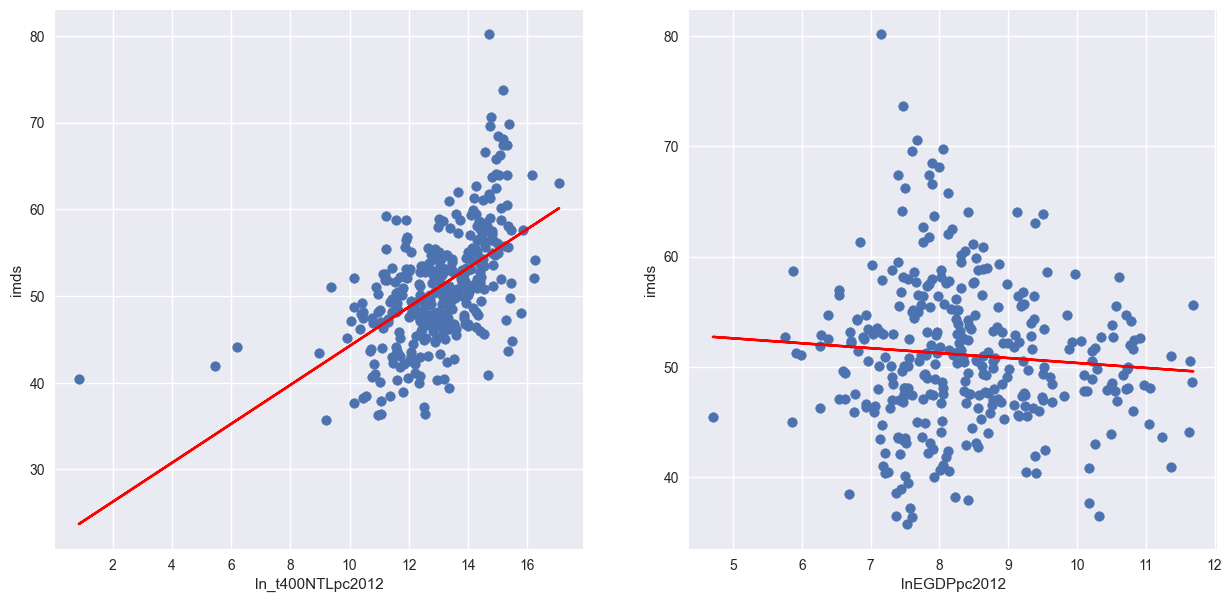

In [370]:
fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(15,7))

#----- ax1
ax1.scatter(x=sat_mod["ln_t400NTLpc2012"], y=sdg_indexes['imds'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="imds")

# add trendline
z = np.polyfit(sat_mod["ln_t400NTLpc2012"], sdg_indexes['imds'], 1)
p = np.poly1d(z)
ax1.plot(sat_mod["ln_t400NTLpc2012"],p(sat_mod["ln_t400NTLpc2012"]), "r-")

#----- ax2
ax2.scatter(x=sat_mod["lnEGDPpc2012"], y=sdg_indexes['imds'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="imds");

# add trendline
z = np.polyfit(sat_mod["lnEGDPpc2012"], sdg_indexes['imds'], 1)
p = np.poly1d(z)
ax2.plot(sat_mod["lnEGDPpc2012"], p(sat_mod["lnEGDPpc2012"]), "r-")

In [371]:
ntl_imds = sat_mod["ln_t400NTLpc2012"].corr(sdg_indexes['imds'])
egdp_imds = sat_mod["lnEGDPpc2012"].corr(sdg_indexes['imds'])

print(f"Correlation of ntl and imds: {ntl_imds}")
print(f"Correlation of egdp and imds: {egdp_imds}")

Correlation of ntl and imds: 0.5548280194761073
Correlation of egdp and imds: -0.08182429944254284


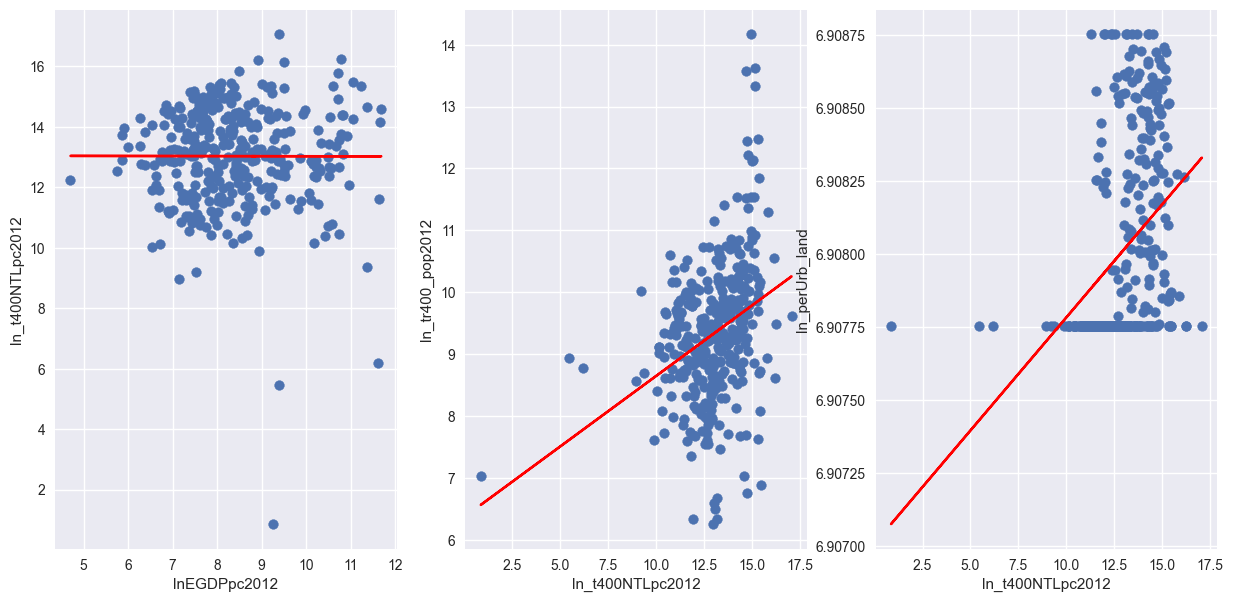

In [372]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=sat_mod['lnEGDPpc2012'], y=sat_mod["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(sat_mod["lnEGDPpc2012"], sat_mod['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(sat_mod["lnEGDPpc2012"],p(sat_mod["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=sat_mod["ln_t400NTLpc2012"], y=sat_mod['ln_tr400_pop2012'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(sat_mod["ln_t400NTLpc2012"], sat_mod['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(sat_mod["ln_t400NTLpc2012"],p(sat_mod["ln_t400NTLpc2012"]),"r-")

#----- ax2
ax2.scatter(x=sat_mod["ln_t400NTLpc2012"], y=sat_mod['ln_perUrb_land2012'])
ax2.set(xlabel="ln_t400NTLpc2012", ylabel="ln_perUrb_land")

# add trendline
z = np.polyfit(sat_mod["ln_t400NTLpc2012"], sat_mod['ln_perUrb_land2012'], 1)
p = np.poly1d(z)
ax2.plot(sat_mod["ln_t400NTLpc2012"],p(sat_mod["ln_t400NTLpc2012"]),"r-");



In [373]:
egdp_ntl = sat_mod["lnEGDPpc2012"].corr(sat_mod['ln_t400NTLpc2012'])
egdp_pop = sat_mod["ln_t400NTLpc2012"].corr(sat_mod['ln_tr400_pop2012'])
egdp_urb = sat_mod["ln_t400NTLpc2012"].corr(sat_mod['ln_perUrb_land2012'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

Correlation of egdp and ntl: -0.0013160348349785576
Correlation of egdp and pop: 0.3324972344406324
Correlation of egdp and Urban land %: 0.3744299375753733


# **Regression models**

### Linear model

In [374]:
x = sat_mod[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land2012',  "ln_pm25_2012", "ln_land_temp2012", 'ln_dist_road2017','ln_ghsl2015']]
y = sdg_indexes['imds']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

model = LinearRegression()


# r2 
#lr = model.score(x_test, y_test)
lr = np.mean(cross_val_score(model, x, y))

# MAE
lr_mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))

model.fit(x_train,y_train)
lr_y_pred = model.predict(x_test)


### Ridge  model

In [375]:

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rid_model = linear_model.Ridge()

# r2
ri = np.mean(cross_val_score(rid_model, x, y))

# MAE
ri_mae = np.mean(cross_val_score(rid_model, x, y, scoring="neg_mean_absolute_error"))

rid_model.fit(x_train, y_train)
ri_y_pred = rid_model.predict(x_test)

### Random Forest Regressor model

In [376]:

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rf_model = RandomForestRegressor()

# r2
rf = np.mean(cross_val_score(rf_model, x, y))

# MAE
rf_mae = np.mean(cross_val_score(rf_model, x, y, scoring="neg_mean_absolute_error"))

rf_model.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)

### Results 

In [377]:
print("R2 for the regressor models")
print(f" Linear model  cv ->   R2: {lr*100:.2f}%,  MAE: {lr_mae:.2f}")
print(f" Ridger model  cv ->   R2: {ri*100:.2f}%,  MAE: {ri_mae:.2f}")
print(f" RF model      cv ->   R2: {rf*100:.2f}%,  MAE: {rf_mae:.2f} ")

R2 for the regressor models
 Linear model  cv ->   R2: 47.83%,  MAE: -3.85
 Ridger model  cv ->   R2: 46.08%,  MAE: -3.88
 RF model      cv ->   R2: 48.40%,  MAE: -3.70 


### Correlation between predicted and truth data

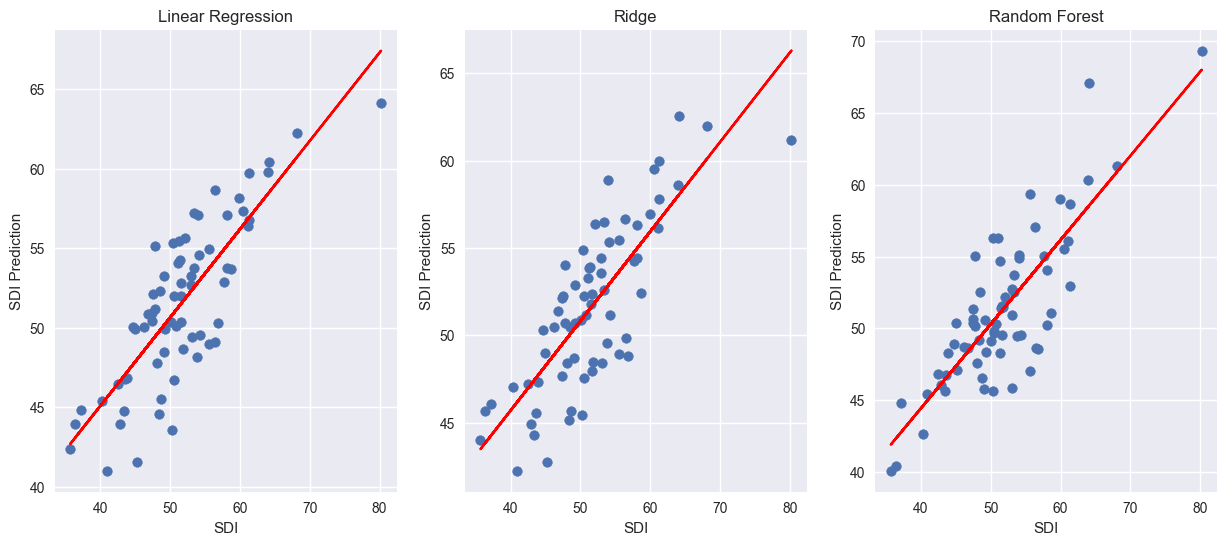

In [378]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize = (15, 6))

ax0.scatter(x = y_test, y = lr_y_pred)
ax0.set(xlabel="SDI", ylabel="SDI Prediction", title="Linear Regression")

# add trendline
z = np.polyfit(y_test, lr_y_pred, 1)
p = np.poly1d(z)
ax0.plot(y_test,p(y_test),"r-")


ax1.scatter(x=y_test, y = ri_y_pred)
ax1.set(xlabel="SDI", ylabel="SDI Prediction", title="Ridge")

# add trendline
z = np.polyfit(y_test, ri_y_pred, 1)
p = np.poly1d(z)
ax1.plot(y_test,p(y_test),"r-")


ax2.scatter(x=y_test, y=rf_y_pred)
ax2.set(xlabel="SDI", ylabel="SDI Prediction", title="Random Forest")


# add trendline
z = np.polyfit(y_test, rf_y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test,p(y_test),"r-")


# **Categorical analysis**

In [379]:
quantile_labels = ["low", 'medium-low', 'medium-high', 'high']

cat_sat_mod = sat_mod
cat_sat_mod["imds_quantile"] = pd.qcut(sdg_indexes["imds"], q=4, labels=quantile_labels)
#df["imds_quantile"]

In [380]:
x = cat_sat_mod[["ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 'ln_land_temp2012', 'lnagr_land2012', 'lnurb_land2012', 'ln_dist_road2017','ln_ghsl2015']].fillna(0)
y = cat_sat_mod['imds_quantile']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

clf = RandomForestClassifier()
#clf.get_params()
clf.fit(x_train,y_train);

y_preds = clf.predict(x_test)

#evaluate the model
#print(f" Train data score: {clf.score(x_train, y_train)*100:.2f}%")
print(f" Test data score: {clf.score(x_test, y_test)*100:.2f}%")
rf_cl = clf.score(x_test, y_test)

 Test data score: 45.59%


In [381]:
#print(classification_report(y_test, y_preds))

In [382]:
#print(confusion_matrix(y_test, y_preds))

In [383]:
#accuracy_score(y_test, y_preds)

In [384]:
# improve model

np.random.seed(42)
for i in range(10, 100, 10):
    print(f"Trying model with {i} stimators")
    clf = RandomForestClassifier(n_estimators=i).fit(x_train, y_train)
    print(f"Model acurracy is {clf.score(x_test, y_test)*100:.2f}%")

Trying model with 10 stimators
Model acurracy is 38.24%
Trying model with 20 stimators
Model acurracy is 48.53%
Trying model with 30 stimators
Model acurracy is 44.12%
Trying model with 40 stimators
Model acurracy is 47.06%
Trying model with 50 stimators
Model acurracy is 44.12%
Trying model with 60 stimators
Model acurracy is 44.12%
Trying model with 70 stimators
Model acurracy is 47.06%
Trying model with 80 stimators
Model acurracy is 47.06%
Trying model with 90 stimators
Model acurracy is 47.06%


In [385]:
#pickle.dump(clf, open("random_forest_model.pkl", "wb"))

#load_model = pickle.load(open("random_forest_model.pkl", "rb"))
#load_model.score(x_test, y_test)

### Linear SVC Classifier

In [386]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

sgd_cla = svm.LinearSVC(dual="auto", max_iter=10000)
sgd_cla.fit(x_train, y_train)
sgd_cl = sgd_cla.score(x_test, y_test)

### Naive Bayes Classifier

In [387]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

naive_cla = GaussianNB()
naive_cla.fit(x_train, y_train)
naive_cl = naive_cla.score(x_test, y_test)

### Results 

In [388]:
print("R2 for the classifier models")
print(f" Random Forest model: {rf_cl*100:.2f}%")
print(f" Linear SVC model: {sgd_cl*100:.2f}%")
print(f" Naive Bayes model: {naive_cl*100:.2f}%")

R2 for the classifier models
 Random Forest model: 45.59%
 Linear SVC model: 44.12%
 Naive Bayes model: 39.71%


# Iterate regression models

In [389]:
y_variables = sdg_indexes[['index_sdg1', 'index_sdg2', 'index_sdg3', 'index_sdg4',
       'index_sdg5', 'index_sdg6', 'index_sdg7', 'index_sdg8', 'index_sdg9',
       'index_sdg10', 'index_sdg11', 'index_sdg13', 'index_sdg15',
       'index_sdg16', 'index_sdg17', 'imds']]

In [390]:
indicators = bol[]

SyntaxError: invalid syntax (864766773.py, line 1)

### Linear Regression

In [ ]:

model_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])

y_variables = sdg_indexes[['index_sdg1', 'index_sdg2', 'index_sdg3', 'index_sdg4',
       'index_sdg5', 'index_sdg6', 'index_sdg7', 'index_sdg8', 'index_sdg9',
       'index_sdg10', 'index_sdg11', 'index_sdg13', 'index_sdg15',
       'index_sdg16', 'index_sdg17', 'imds']]

x = sat_mod[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 'ln_land_temp2012', 'ln_dist_road2017','ln_ghsl2015']]

for y_variable in y_variables:

    y = y_variables[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    model = LinearRegression()

    #mse = mean_squared_error(y_test, y_pred)
    r2 = np.mean(cross_val_score(model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))
    model_results.loc[len(model_results.index)] = [y_variable, r2, mae]

    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

In [ ]:
model_results[model_results["r2"]>0.9]

In [ ]:
model_results[model_results["r2"]>0.8]

In [ ]:
model_results[model_results["r2"]>0.7]

In [ ]:
model_results[model_results["r2"]>0]

### Random Forest Regressor

In [ ]:
model_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])
predict_df = pd.DataFrame()

In [ ]:
x = sat_mod[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 'ln_land_temp2012', 'ln_dist_road2017','ln_ghsl2015']]

for y_variable in y_variables:

    y = y_variables[y_variable]
 
    
    #Set up the model
    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 
    model = RandomForestRegressor()
    
    #mse = mean_squared_error(y_test, y_pred)
    r2 = np.mean(cross_val_score(model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))
    
    # Add to the results df 
    model_results.loc[len(model_results.index)] = [y_variable, r2, mae]

    # Prediction df 
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

    col0 = y_variable + "_true"
    col1 = y_variable + "_pred"
    temp_predict = pd.DataFrame({col0: y_test, col1: y_pred}, index=y_test.index)
    temp_predict.index.name = "id"
    
    if predict_df.empty:
        predict_df = temp_predict
    else:
        predict_df = predict_df.merge(temp_predict, on="id", how="outer")


In [ ]:
model_results[model_results["r2"]>0.9].round(2)

In [ ]:
model_results[model_results["r2"]>0.8].round(2)

In [ ]:
model_results[(model_results["r2"]>=0.7) & (model_results["r2"]<0.8)].round(2)

In [ ]:
model_results[(model_results["r2"]>=0.6) & (model_results["r2"]<0.7)].round(2)

In [ ]:
model_results[model_results["r2"]>0].round(2)

In [ ]:
model_results[model_results["r2"]<0].round(2)

In [ ]:
fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(nrows=1, 
                                         ncols=4, 
                                         figsize=(20, 7))

# Graph 1 
g_x = predict_df["index_sdg1_true"]
g_y = predict_df["index_sdg1_pred"]

ax0.scatter(x = g_x, y = g_y)
ax0.set(xlabel="sdg1_1_pubn_abs_true", ylabel="sdg1_1_pubn_abs_pred", title="index_sdg1")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax0.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = predict_df["index_sdg7_true"]
g_y = predict_df["index_sdg7_pred"]

ax1.scatter(x = g_x, y = g_y)
ax1.set(xlabel="sdg8_5_ompr_abs_true", ylabel="sdg8_5_ompr_abs_pred", title="index_sdg7")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax1.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = predict_df["index_sdg11_true"]
g_y = predict_df["index_sdg11_pred"]

ax2.scatter(x = g_x, y = g_y)
ax2.set(xlabel="sdg8_5_ofpr_abs_true", ylabel="sdg8_5_ofpr_abs_pred", title="index_sdg11")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax2.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = predict_df["imds_true"]
g_y = predict_df["imds_pred"]

ax3.scatter(x = g_x, y = g_y)
ax3.set(xlabel="sdg8_6_wlm_abs_true", ylabel="sdg8_6_wlm_abs_pred", title="imds")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax3.plot(g_x,p(g_x),"r-")